# Fake News Detection – Transformer Approach

This notebook implements a complete transformer‑based pipeline for fake news detection using DistilBERT. It follows the methodology outlined in the thesis and is designed to run in Google Colab. The notebook loads the LIAR dataset, converts the labels to a binary scheme, prepares the data for fine‑tuning a DistilBERT model, trains the model using the Hugging Face `Trainer` API, evaluates performance on the validation and test sets, visualises results, applies SHAP for interpretability, and saves predictions for statistical comparison with the classical model.

## How to run (Colab/Local)
1. **Install dependencies:** Run the first code cell to install required packages. In Colab this cell runs `!pip install` commands. Locally, ensure `transformers`, `datasets`, `torch`, `shap`, `pandas`, `numpy`, and `matplotlib` are installed.
2. **Data path:** Set the `DATA_PATH` variable in the data loading cell to point to the directory containing `train.tsv`, `valid.tsv`, and `test.tsv`. If left blank, the notebook assumes they are in the working directory.
3. **Run all cells in order:** Execute each cell sequentially. The notebook will load the data, fine-tune the model, evaluate it, generate explainability plots and save artefacts.
4. **Artefacts:** Metrics, predictions and figures will be saved in the `artefacts/` directory for inclusion in your thesis appendices.


## 1 Setup

Install the required libraries (Transformers, Datasets, PyTorch, SHAP, etc.) and import them. Random seeds are set to ensure reproducibility. Note that using a GPU in Colab is strongly recommended for training efficiency.

In [ ]:
# Optionally upload and extract liar_dataset.zip
import os, zipfile

# Initialize DATA_PATH as empty; it will be updated if a zip is uploaded or found
DATA_PATH = 'liar_dataset'

# Try to use Google Colab's file upload if available
try:
    from google.colab import files
    print("If you have a liar_dataset.zip file, please upload it now. Otherwise, skip.")
    uploaded = files.upload()
    for fn in uploaded.keys():
        if fn.endswith('.zip'):
            zip_path = fn
            extract_dir = 'liar_dataset' # Define extract directory
            os.makedirs(extract_dir, exist_ok=True)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            DATA_PATH = extract_dir # Set DATA_PATH to extraction directory
            print(f'Extracted {zip_path} to {extract_dir}')
except Exception as colab_ex:
    # Fallback for local runtime: look for liar_dataset.zip in current directory
    zip_name = 'liar_dataset.zip'
    if os.path.exists(zip_name):
        extract_dir = 'liar_dataset' # Define extract directory
        os.makedirs(extract_dir, exist_ok=True)
        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        DATA_PATH = extract_dir # Set DATA_PATH to extraction directory
        print(f'Found and extracted {zip_name} into {extract_dir}')
    else:
        # If no zip is found, leave DATA_PATH empty; user should set it manually below
        DATA_PATH = 'liar_dataset'

# --- Add diagnostics here ---
print(f"DATA_PATH is set to: '{DATA_PATH}'")
if DATA_PATH and os.path.exists(DATA_PATH):
    print(f"Contents of {DATA_PATH}:")
    for item in os.listdir(DATA_PATH):
        print(f"- {item}")
elif DATA_PATH:
    print(f"Error: DATA_PATH '{DATA_PATH}' does not exist.")
else:
    print("DATA_PATH is empty. TSV files must be in the current directory or DATA_PATH must be set manually in the next cell.")
# --- End diagnostics ---

If you have a liar_dataset.zip file, please upload it now. Otherwise, skip.


Saving liar_dataset.zip to liar_dataset.zip
Extracted liar_dataset.zip to liar_dataset
DATA_PATH is set to: 'liar_dataset'
Contents of liar_dataset:
- train.tsv
- README
- test.tsv
- valid.tsv


In [ ]:
# Install and import necessary packages; set random seed and determine device (CPU/GPU)
# Install necessary packages (run in Colab)

!pip install -q transformers datasets torch shap scikit-learn pandas numpy matplotlib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
from transformers import (
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import Dataset

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)

import shap
import pickle

# Set random seeds
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


## 2 Data Loading

We load the LIAR dataset from TSV files located in `DATA_PATH`. If these files are not available locally, you can instead load the dataset using `datasets.load_dataset('liar')` provided your environment has internet access. The labels are converted to a binary scheme consistent with the classical notebook.

In [ ]:
# Load the LIAR dataset from TSV files and convert the six original labels to binary classes (1=Fake, 0=Real)
# The DATA_PATH variable is set in the previous cell after extracting the dataset.
# Ensure the previous cell has run successfully to set DATA_PATH.

import os # Import the os library
import pandas as pd # Import pandas here as it's used in the exception block print

# Explicitly set DATA_PATH for this cell as a workaround if the variable state is inconsistent
DATA_PATH = 'liar_dataset'

# Columns for the TSV files
columns = [
    'id', 'label', 'statement', 'subject', 'speaker', 'speaker_title', 'state', 'party',
    'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts',
    'pants_on_fire_counts', 'context'
]

# Attempt to load from TSV files using the DATA_PATH
try:
    # Get the absolute path for the data directory
    # Ensure DATA_PATH is defined before using os.path.abspath
    if 'DATA_PATH' not in locals() and 'DATA_PATH' not in globals():
         DATA_PATH = '' # Initialize if not already set (though it should be from the previous cell)

    abs_data_path = os.path.abspath(DATA_PATH)
    print(f"Attempting to load from absolute path: {abs_data_path}")

    # Assuming the TSV files are tab-separated and might have quotes within fields
    train_df = pd.read_csv(os.path.join(abs_data_path, 'train.tsv'), sep='\t', header=None, names=columns, quoting=3)
    valid_df = pd.read_csv(os.path.join(abs_data_path, 'valid.tsv'), sep='\t', header=None, names=columns, quoting=3)
    test_df  = pd.read_csv(os.path.join(abs_data_path, 'test.tsv'),  sep='\t', header=None, names=columns, quoting=3)
    print(f'Successfully loaded LIAR TSV files from {abs_data_path}.')
except Exception as manual_e:
    # Access DATA_PATH safely for printing in the error message
    data_path_for_error = ''
    try:
        # Try to get the value of DATA_PATH if it exists
        data_path_for_error = str(DATA_PATH)
    except NameError:
        data_path_for_error = 'DATA_PATH is not defined'

    print(f"Failed to load from TSV files at {data_path_for_error}:", manual_e) # Use the safe variable here
    print("Please ensure the previous cell ran successfully and the LIAR TSV files exist in the directory specified by DATA_PATH.")
    # If data loading is critical, raise the exception
    raise manual_e


# Convert labels to binary
# The original labels from TSV files are strings
false_labels_tsv = {'pants-fire','pants on fire','false','barely-true'}
true_labels_tsv  = {'half-true','mostly-true','true'}


def to_binary(label):
    if isinstance(label, str):
        # Handle string labels from TSV
        if label.lower() in false_labels_tsv:
            return 1 # Fake
        elif label.lower() in true_labels_tsv:
            return 0 # Real
    return None # Should not happen with valid LIAR labels

for df in (train_df, valid_df, test_df):
    if 'label' in df.columns:
        # Ensure the label column is treated consistently; apply conversion
        df['binary_label'] = df['label'].apply(to_binary)

        df['label'] = df['binary_label'] # Replace original label with binary label
        df.drop(columns=['binary_label'], inplace=True) # Drop temporary column

print('Train size:', len(train_df), 'Validation size:', len(valid_df), 'Test size:', len(test_df))
print('Label distribution in training set:', train_df['label'].value_counts().to_dict())

Attempting to load from absolute path: /content/liar_dataset
Successfully loaded LIAR TSV files from /content/liar_dataset.
Train size: 10269 Validation size: 1284 Test size: 1283
Label distribution in training set: {0: 5772, 1: 4497}


## 3 Minimal Text Preprocessing

For transformer models we avoid heavy preprocessing in order to preserve the context and syntax. We only normalise whitespace and remove excessive punctuation. A new column `processed_text` is created.

In [ ]:
# Minimal text preprocessing: normalise whitespace and reduce repeated punctuation; heavy cleaning is avoided to preserve context for the transformer
import re

def preprocess_text_transformer(text):
    if pd.isna(text):
        return ''
    text = str(text).strip()
    # Normalise whitespace
    text = re.sub('\s+', ' ', text)
    # Replace sequences of punctuation with a single instance
    text = re.sub('[.!?]{2,}', lambda m: m.group(0)[0], text)
    return text

for df in (train_df, valid_df, test_df):
    df['processed_text'] = df['statement'].apply(preprocess_text_transformer)

# Show an example
print(train_df[['statement','processed_text']].head(1))


                                           statement  \
0  Says the Annies List political group supports ...   

                                      processed_text  
0  Says the Annies List political group supports ...  


## 4 Tokenisation and Dataset Preparation

We initialise the DistilBERT tokenizer and convert the data into Hugging Face `Dataset` objects. Each example is tokenised, padded or truncated to a maximum length, and accompanied by an attention mask.

In [ ]:
# Initialise the DistilBERT tokenizer, convert the data into Hugging Face Dataset objects, tokenise the text into input IDs and attention masks, and set the format for PyTorch
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 256

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
print('Tokenizer loaded')

# Create Hugging Face Datasets
def create_dataset(df):
    return Dataset.from_dict({
        'text': df['processed_text'].tolist(),
        'labels': df['label'].tolist()
    })

train_dataset = create_dataset(train_df)
valid_dataset = create_dataset(valid_df)
test_dataset  = create_dataset(test_df)

# Tokenization function
def tokenize_batch(batch):
    return tokenizer(
        batch['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

train_dataset = train_dataset.map(tokenize_batch, batched=True)
valid_dataset = valid_dataset.map(tokenize_batch, batched=True)
test_dataset  = test_dataset.map(tokenize_batch,  batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
valid_dataset.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
test_dataset.set_format(type='torch',  columns=['input_ids','attention_mask','labels'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizer loaded


Map:   0%|          | 0/10269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

## 5 Model Initialisation and Fine‑Tuning

We load the pre‑trained DistilBERT model with a classification head for two classes. Training is performed using the Hugging Face `Trainer` API. We specify a learning rate of 2e‑5, a batch size of 16 (or 8 on CPU), and train for three epochs. Early stopping is enabled to reduce over‑fitting; adjust `EPOCHS` or remove the callback if you want to train longer.

In [ ]:
# Initialise a pre‑trained DistilBERT model for sequence classification; define the training hyperparameters and instantiate a Trainer with early stopping
# Load model
from transformers import DistilBertForSequenceClassification # import the class here
import torch # import torch here

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

MODEL_NAME = 'distilbert-base-uncased' # Define MODEL_NAME here

model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

# Define metrics function for the Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    # Compute probabilities for AUC
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy() if logits.shape[1] > 1 else (logits[:, 0] > 0).astype(float)

    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, pos_label=1),
        'recall': recall_score(labels, preds, pos_label=1),
        'f1': f1_score(labels, preds, pos_label=1),
        'auc': roc_auc_score(labels, probs),
        'mcc': matthews_corrcoef(labels, preds)
    }

# Training arguments
EPOCHS = 3
BATCH_SIZE = 16 if torch.cuda.is_available() else 8
training_args = TrainingArguments(
    output_dir='./distilbert_fake_news',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy='epoch',  # Corrected parameter name
    save_strategy='epoch',
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    seed=RANDOM_STATE,
    report_to="none" # Disable reporting to services like wandb
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print('Starting training...')
train_result = trainer.train()
print('Training completed')

Using device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Mcc
1,0.656800,0.668854,0.598910,0.666667,0.327922,0.439608,0.675405,0.207931
2,0.605800,0.648521,0.649533,0.645614,0.597403,0.620573,0.686523,0.296637
3,0.545500,0.705916,0.631620,0.637765,0.537338,0.583260,0.683765,0.260517


Training completed


## 6 Evaluation

After fine‑tuning, we evaluate the model on the validation and test sets. We compute accuracy, precision, recall, F1 and AUC, display a classification report, draw a confusion matrix and ROC curve, and save the test predictions for later statistical testing.

Validation metrics:
  accuracy: 0.6495
  precision: 0.6456
  recall: 0.5974
  f1: 0.6206
  auc: 0.6865
  mcc: 0.2966

Test metrics:
  accuracy: 0.6563
  precision: 0.6117
  recall: 0.5665
  f1: 0.5882
  auc: 0.6896
  mcc: 0.2946

Classification report (test set):
              precision    recall  f1-score   support

        Real       0.69      0.72      0.71       727
        Fake       0.61      0.57      0.59       556

    accuracy                           0.66      1283
   macro avg       0.65      0.65      0.65      1283
weighted avg       0.65      0.66      0.65      1283



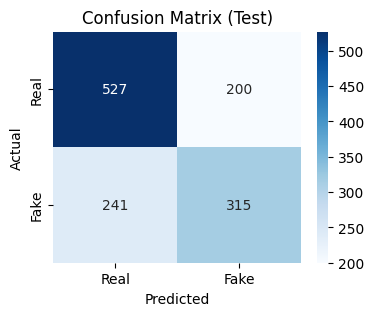

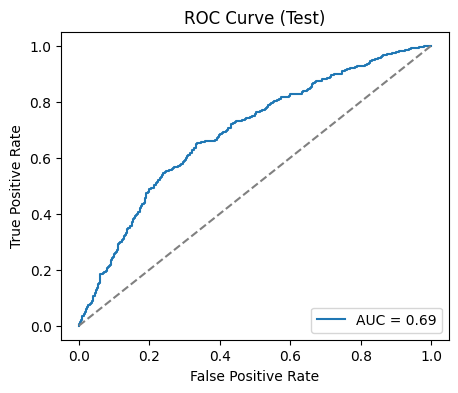

Saved metrics to artefacts/metrics_transformer.json and predictions to artefacts/predictions_transformer.csv


In [ ]:
# Evaluate the trained model on the validation and test sets; compute metrics, show classification report, confusion matrix and ROC curve; save metrics and predictions to artefacts
# Validation evaluation
val_outputs = trainer.predict(valid_dataset)
val_logits = val_outputs.predictions
val_labels = val_outputs.label_ids
val_preds = np.argmax(val_logits, axis=1)
val_probs = torch.softmax(torch.tensor(val_logits), dim=1)[:, 1].numpy()
val_metrics = {
    'accuracy': accuracy_score(val_labels, val_preds),
    'precision': precision_score(val_labels, val_preds, pos_label=1),
    'recall': recall_score(val_labels, val_preds, pos_label=1),
    'f1': f1_score(val_labels, val_preds, pos_label=1),
    'auc': roc_auc_score(val_labels, val_probs),
    'mcc': matthews_corrcoef(val_labels, val_preds)
}

# Test evaluation
preds_output = trainer.predict(test_dataset)
test_logits = preds_output.predictions
test_labels = preds_output.label_ids
test_preds = np.argmax(test_logits, axis=1)
probs = torch.softmax(torch.tensor(test_logits), dim=1)[:, 1].numpy()
test_metrics = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'precision': precision_score(test_labels, test_preds, pos_label=1),
    'recall': recall_score(test_labels, test_preds, pos_label=1),
    'f1': f1_score(test_labels, test_preds, pos_label=1),
    'auc': roc_auc_score(test_labels, probs),
    'mcc': matthews_corrcoef(test_labels, test_preds)
}

# Print metrics
print('Validation metrics:')
for k, v in val_metrics.items():
    print(f'  {k}: {v:.4f}')
print('\nTest metrics:')
for k, v in test_metrics.items():
    print(f'  {k}: {v:.4f}')

print('\nClassification report (test set):')
print(classification_report(test_labels, test_preds, target_names=['Real','Fake']))

# Create artefacts directory
import os, json, pandas as pd
os.makedirs('artefacts', exist_ok=True)

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'], ax=ax1)
ax1.set_title('Confusion Matrix (Test)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
fig1.savefig('artefacts/confusion_matrix_transformer.png')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(test_labels, probs, pos_label=1)
auc_score = test_metrics['auc']
fig2, ax2 = plt.subplots(figsize=(5, 4))
ax2.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax2.plot([0,1],[0,1],'--', color='gray')
ax2.set_title('ROC Curve (Test)')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc='lower right')
fig2.savefig('artefacts/roc_curve_transformer.png')
plt.show()

# Save metrics
metrics_out = {'val_metrics': val_metrics, 'test_metrics': test_metrics}
with open('artefacts/metrics_transformer.json', 'w') as f:
    json.dump(metrics_out, f)

# Save predictions to CSV
pred_df = pd.DataFrame({'y_true': test_labels.tolist(), 'y_pred': test_preds.tolist(), 'y_proba': probs.tolist()})
pred_df.to_csv('artefacts/predictions_transformer.csv', index=False)
print('Saved metrics to artefacts/metrics_transformer.json and predictions to artefacts/predictions_transformer.csv')

# Cross‑validation evaluation: estimate performance variability across folds


In [ ]:
# Retreina o codigo em cada fold
from sklearn.model_selection import StratifiedKFold # Use StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
import numpy as np, json, os
from datasets import Dataset
import torch
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import pandas as pd # Import pandas here

# Combine train and validation data for cross‑validation
combined_df = pd.concat([train_df, valid_df], ignore_index=True)
all_texts = combined_df['processed_text'].tolist()
all_labels = combined_df['label'].tolist()

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Lists to store metrics for each fold
# Initialize fold_metrics with mcc key
fold_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': [], 'mcc': []}

# loop through folds
for fold, (train_index, val_index) in enumerate(kf.split(all_texts, all_labels)): # Split based on labels
    print(f'Starting Fold {fold+1}/5')

    # creating train and validation splits for the current fold
    train_texts_fold = [all_texts[i] for i in train_index]
    train_labels_fold = [all_labels[i] for i in train_index]
    val_texts_fold = [all_texts[i] for i in val_index]
    val_labels_fold = [all_labels[i] for i in val_index]

    # Create Hugging Face Datasets for the current fold
    train_dataset_fold = Dataset.from_dict({'text': train_texts_fold, 'labels': train_labels_fold})
    valid_dataset_fold = Dataset.from_dict({'text': val_texts_fold, 'labels': val_labels_fold})

    # Tokenize the datasets for the current fold
    train_dataset_fold = train_dataset_fold.map(tokenize_batch, batched=True)
    valid_dataset_fold = valid_dataset_fold.map(tokenize_batch, batched=True)

    # Set format for PyTorch
    train_dataset_fold.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
    valid_dataset_fold.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

    # Re-initialize the model for each fold
    model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    model.to(device)

    # Define training arguments for the current fold
    training_args_fold = TrainingArguments(
        output_dir=f'./distilbert_fake_news_fold_{fold+1}', # Unique output directory for each fold
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        eval_strategy='epoch',  # Corrected parameter name
        save_strategy='epoch',
        learning_rate=2e-5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        seed=RANDOM_STATE + fold, # Use a slightly different seed for each fold
        report_to="none"
    )

    # Initialize the Trainer for the current fold
    trainer = Trainer(
        model=model,
        args=training_args_fold,
        train_dataset=train_dataset_fold,
        eval_dataset=valid_dataset_fold,
        compute_metrics=compute_metrics, # Use the existing compute_metrics
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train the model for the current fold
    print(f'Training Fold {fold+1}/5...')
    trainer.train()
    print(f'Training Fold {fold+1}/5 Completed.')

    # Evaluate the model on the validation set for the current fold
    eval_result = trainer.evaluate()

    # Store the metrics for the current fold, ensuring consistent naming
    fold_metrics['accuracy'].append(eval_result.get('eval_accuracy'))
    fold_metrics['precision'].append(eval_result.get('eval_precision'))
    fold_metrics['recall'].append(eval_result.get('eval_recall'))
    fold_metrics['f1'].append(eval_result.get('eval_f1'))
    fold_metrics['auc'].append(eval_result.get('eval_auc'))
    # Correctly access and append the MCC value
    fold_metrics['mcc'].append(eval_result.get('eval_mcc'))


# After the loop, compute and print the average metrics
print('\nCross-validation results (5-fold):')
cv_results_summary = {}
for metric, values in fold_metrics.items():
    # Filter out None values before calculating mean and std
    valid_values = [v for v in values if v is not None]
    if valid_values:
        mean_val = np.mean(valid_values)
        std_val = np.std(valid_values)
        cv_results_summary[metric] = {"mean": mean_val, "std": std_val}
        print(f'  {metric}: {mean_val:.4f} ± {std_val:.4f}')
    else:
        print(f'  {metric}: No valid data')


# Optionally save the cross-validation results
os.makedirs('artefacts', exist_ok=True)

# Load existing metrics if the file exists, otherwise initialize an empty dictionary
try:
    with open('artefacts/metrics_transformer.json', 'r') as f:
        metrics_data = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    metrics_data = {}

metrics_data['cross_validation_metrics'] = cv_results_summary

with open('artefacts/metrics_transformer.json', 'w') as f:
    json.dump(metrics_data, f, indent=4)

print('\nCross-validation metrics saved to artefacts/metrics_transformer.json')

Starting Fold 1/5


Map:   0%|          | 0/9242 [00:00<?, ? examples/s]

Map:   0%|          | 0/2311 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Fold 1/5...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Mcc
1,0.661300,0.639499,0.627434,0.579882,0.574780,0.577320,0.675279,0.244263
2,0.605300,0.653295,0.630463,0.588482,0.549365,0.568251,0.673708,0.246367
3,0.531900,0.695619,0.632194,0.591341,0.547410,0.568528,0.667299,0.249409


Training Fold 1/5 Completed.


Starting Fold 2/5


Map:   0%|          | 0/9242 [00:00<?, ? examples/s]

Map:   0%|          | 0/2311 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Fold 2/5...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Mcc
1,0.659500,0.665726,0.603202,0.668790,0.205279,0.314136,0.667382,0.180521
2,0.599100,0.640165,0.645608,0.633508,0.473118,0.541690,0.685504,0.270010
3,0.530800,0.699014,0.632194,0.596865,0.521017,0.556367,0.674190,0.246362


Training Fold 2/5 Completed.


Starting Fold 3/5


Map:   0%|          | 0/9242 [00:00<?, ? examples/s]

Map:   0%|          | 0/2311 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Fold 3/5...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Mcc
1,0.658900,0.643426,0.620078,0.559868,0.662757,0.606983,0.676438,0.247580
2,0.605400,0.643508,0.649502,0.622555,0.528837,0.571882,0.685216,0.281149
3,0.532200,0.696586,0.646906,0.625151,0.505376,0.558919,0.679320,0.274264


Training Fold 3/5 Completed.


Starting Fold 4/5


Map:   0%|          | 0/9243 [00:00<?, ? examples/s]

Map:   0%|          | 0/2310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Fold 4/5...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Mcc
1,0.660500,0.653253,0.622078,0.565523,0.629159,0.595646,0.666665,0.244014
2,0.602100,0.663151,0.632035,0.613757,0.454012,0.521935,0.670019,0.240604
3,0.527600,0.720229,0.624675,0.589183,0.500978,0.541512,0.663939,0.229462


Training Fold 4/5 Completed.


Starting Fold 5/5


Map:   0%|          | 0/9243 [00:00<?, ? examples/s]

Map:   0%|          | 0/2310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Fold 5/5...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Mcc
1,0.659200,0.649885,0.623810,0.594561,0.470646,0.525396,0.655288,0.224878
2,0.610000,0.656692,0.632468,0.637084,0.393346,0.486388,0.672257,0.240267
3,0.541300,0.694057,0.630736,0.587384,0.555773,0.571141,0.667060,0.247657


Training Fold 5/5 Completed.



Cross-validation results (5-fold):
  accuracy: 0.6265 ± 0.0047
  precision: 0.5779 ± 0.0137
  recall: 0.5887 ± 0.0510
  f1: 0.5815 ± 0.0179
  auc: 0.6719 ± 0.0042
  mcc: 0.2460 ± 0.0016

Cross-validation metrics saved to artefacts/metrics_transformer.json


## 7 Interpretability with SHAP

SHAP (SHapley Additive exPlanations) provides feature attributions that explain the model’s predictions. In this section we use a `shap.Explainer` with a text masker to explain the decisions of the DistilBERT model. Because transformers are heavy, we sample a small subset of the training data as background. We also measure the consistency of explanations by computing SHAP values twice with different background samples and reporting the Spearman correlation of attributions.

In [ ]:
# Interpretability: use SHAP to compute feature attributions for selected test examples; display the explanations and evaluate consistency by comparing SHAP values using two different background samples
# Select a modest background sample for SHAP
background_texts = train_df['processed_text'].sample(100, random_state=RANDOM_STATE).tolist()

# Define a function to produce the logit for class 1 (fake)
def predict_logit(texts):
    # ensure input is a list of strings
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    elif isinstance(texts, pd.Series):
        texts = texts.tolist()
    elif isinstance(texts, str):
        texts = [texts]
    elif not isinstance(texts, list):
        raise TypeError("Input must be a string, list of strings, NumPy array, or Pandas Series.")

    #ensure all elements in the list are strings
    texts = [str(t) for t in texts]

    enc = tokenizer(texts, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model(**enc)
    logits = outputs.logits.detach().cpu().numpy()
    # Return logits for the "fake" class (index 1)
    return logits[:, 1]

# Initialise SHAP Explainer
explainer = shap.Explainer(predict_logit, masker=shap.maskers.Text(tokenizer), algorithm='partition')

# select a few examples for explanation and explicitly convert to list of strings
example_texts = test_df['processed_text'].sample(2, random_state=RANDOM_STATE).astype(str).tolist()
shap_values = explainer(example_texts)

# Display textual explanations (right now is printing 1 and 2)
for i, text in enumerate(example_texts):
    print(f'\nExample {i+1}: {text[:200]}...' if len(text) > 200 else f'\nExample {i+1}: {text}')
    shap.plots.text(shap_values[i])

# consistency analysis: compute SHAP values with two different backgrounds and correlate
bg1 = train_df['processed_text'].sample(100, random_state=1).astype(str).tolist()
bg2 = train_df['processed_text'].sample(100, random_state=2).astype(str).tolist()
expl1 = shap.Explainer(predict_logit, masker=shap.maskers.Text(tokenizer), algorithm='partition')
expl2 = shap.Explainer(predict_logit, masker=shap.maskers.Text(tokenizer), algorithm='partition')
sv1 = expl1([example_texts[0]])[0].values
sv2 = expl2([example_texts[0]])[0].values
from scipy.stats import spearmanr
rho, pval = spearmanr(sv1, sv2)
print(f'\nSHAP attribution consistency (Spearman r): {rho:.3f}')


Example 1: Nearly 20% of our residents are born abroad.



Example 2: A child born in America today will inherit $1.5 million in debt the moment theyre placed in their mothers arms.



SHAP attribution consistency (Spearman r): 1.000


PartitionExplainer explainer: 21it [00:28,  2.16s/it]


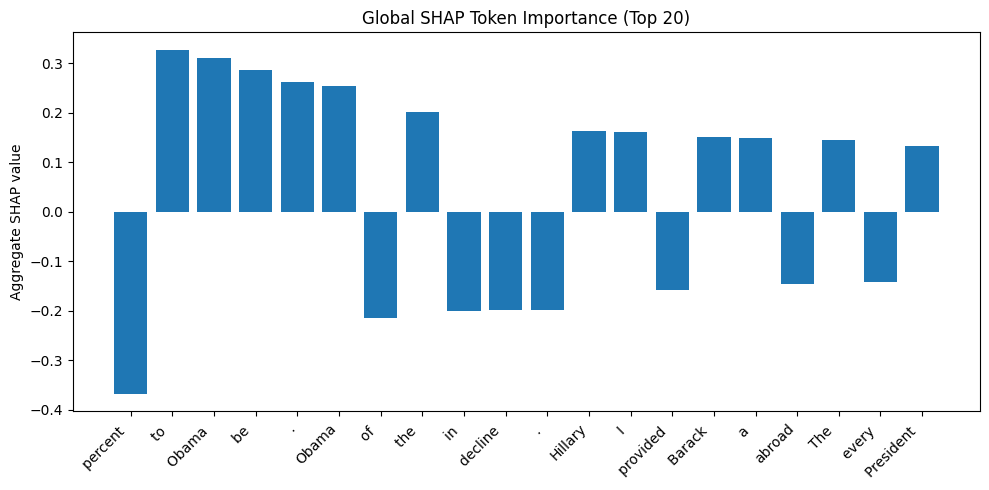

Global SHAP summary saved to artefacts/shap_global_summary.png


In [ ]:
# Global SHAP summary: aggregate token importances across multiple test samples
# This cell samples a subset of the test set, computes SHAP values for each
# example and aggregates the importances of individual tokens. The top 20
# tokens by absolute total contribution are plotted and saved.
from collections import defaultdict
import matplotlib.pyplot as plt
# Select up to 20 examples from the test set
sample_size = min(20, len(test_df))
example_texts = test_df['processed_text'].sample(sample_size, random_state=RANDOM_STATE).astype(str).tolist()
# Compute SHAP values for the sample
shap_values_sample = explainer(example_texts)
# Aggregate contributions for each token
token_scores = defaultdict(float)
for sv in shap_values_sample:
    tokens = sv.data
    values = sv.values
    for token, val in zip(tokens, values):
        token_scores[token] += val
# Select top 20 tokens by absolute aggregate contribution
top_items = sorted(token_scores.items(), key=lambda x: abs(x[1]), reverse=True)[:20]
tokens_top, scores_top = zip(*top_items) if top_items else ([], [])
# Plot the aggregated importances
plt.figure(figsize=(10, 5))
plt.bar(range(len(tokens_top)), scores_top)
plt.xticks(range(len(tokens_top)), tokens_top, rotation=45, ha='right')
plt.title('Global SHAP Token Importance (Top 20)')
plt.ylabel('Aggregate SHAP value')
plt.tight_layout()
os.makedirs('artefacts', exist_ok=True)
plt.savefig('artefacts/shap_global_summary.png')
plt.show()
print('Global SHAP summary saved to artefacts/shap_global_summary.png')


## 8 Conclusion

This notebook trains a DistilBERT model on the LIAR dataset for binary fake news classification. It includes data loading, minimal preprocessing, tokenisation, fine‑tuning, evaluation, visualisation, and interpretability through SHAP. The test predictions are saved to `transformer_test_predictions.pkl` so they can be compared statistically with the classical model using McNemar’s test. You can adjust the hyperparameters, training epochs or model architecture as needed for further experimentation.

In [ ]:
# Print the mean and standard deviation of MCC from the cross-validation results
if 'mcc' in cv_results_summary:
    mcc_mean = cv_results_summary['mcc']['mean']
    mcc_std = cv_results_summary['mcc']['std']
    print(f"Cross-validation MCC: {mcc_mean:.4f} ± {mcc_std:.4f}")
else:
    print("MCC not found in cross-validation results.")

Cross-validation MCC: 0.2460 ± 0.0016
